# Real-Time Bitcoin Data Q&A Bot with DocsGPT

This notebook demonstrates the implementation of a real-time data ingestion, analysis, and interactive Q&A system using Bitcoin price data from the CoinGecko API. The system periodically fetches data, computes statistical metrics such as log returns and volatility, and uses a locally hosted LLM (DocsGPT with LLaMA 2) to answer natural language queries about the data.

## 1.1 Description

- Fetches real-time Bitcoin prices at regular intervals using the CoinGecko API.
- Stores the data with timestamps in a CSV file for persistence.
- Computes time series metrics including:
  - Log returns
  - Rolling volatility
  - Moving averages and Bollinger Bands
- Visualizes Bitcoin price trends and volatility over time using `matplotlib`.
- Detects outliers in price and volatility using custom rules.
- Loads and interacts with a quantized LLaMA 2 model via DocsGPT to answer time series-related user queries.
- Offers an interactive Q&A loop for predefined and custom user questions.

## 1.2 References

- [`BitcoinLLMQA.API.md`](./BitcoinLLMQA.API.md) – API wrapper documentation
- [`BitcoinLLMQA.example.md`](./BitcoinLLMQA.example.md) – Q&A usage examples
- [`BitcoinLLMQA_utils.py`](./BitcoinLLMQA_utils.py) – Utility functions for data processing, analysis, and LLM interaction
- [Jupyter Notebook Style Guide](https://github.com/causify-ai/helpers/blob/master/docs/coding/all.jupyter_notebook.how_to_guide.md)

## 1.3 Citation

- [CoinGecko API](https://www.coingecko.com/en/api)
- [DocsGPT](https://github.com/arc53/DocsGPT)
- LLaMA 2 quantized model (`llama-2-7b-chat.Q4_K_M.gguf`)

## 1.4 Notebook Naming Convention

This notebook follows the `projectname.example.ipynb` naming style:


BitcoinLLMQA.example.ipynb



## Initial Setup
Import dependencies and initialize components

In [1]:
from BitcoinLLMQA_utils import (
    fetch_bitcoin_price,
    update_dataset,
    analyze_data,
    setup_docsgpt,
    handle_query,
    setup_docsgpt,
    add_technical_indicators,
    analyze_time_series,
    create_analysis_plots,
    print_statistical_summary,
    detect_outliers,
    run_bitcoin_chatbot
    
)
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import datetime
from BitcoinLLMQA_utils import backfill_last_n_days_data


In [2]:
# Initialize LLM
llm = setup_docsgpt()

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32              = 

llama_kv_cache_unified: layer  15: dev = CPU
llama_kv_cache_unified: layer  16: dev = CPU
llama_kv_cache_unified: layer  17: dev = CPU
llama_kv_cache_unified: layer  18: dev = CPU
llama_kv_cache_unified: layer  19: dev = CPU
llama_kv_cache_unified: layer  20: dev = CPU
llama_kv_cache_unified: layer  21: dev = CPU
llama_kv_cache_unified: layer  22: dev = CPU
llama_kv_cache_unified: layer  23: dev = CPU
llama_kv_cache_unified: layer  24: dev = CPU
llama_kv_cache_unified: layer  25: dev = CPU
llama_kv_cache_unified: layer  26: dev = CPU
llama_kv_cache_unified: layer  27: dev = CPU
llama_kv_cache_unified: layer  28: dev = CPU
llama_kv_cache_unified: layer  29: dev = CPU
llama_kv_cache_unified: layer  30: dev = CPU
llama_kv_cache_unified: layer  31: dev = CPU
llama_kv_cache_unified:        CPU KV buffer size =  1024.00 MiB
llama_kv_cache_unified: KV self size  = 1024.00 MiB, K (f16):  512.00 MiB, V (f16):  512.00 MiB
llama_context: enumerating backends
llama_context: backend_ptrs.size() = 1

## Real-time Data Collection Simulation
Run for 3 intervals (15 minutes total)

In [3]:
df = pd.read_csv('bitcoin_prices.csv')
display(df.head())

,timestamp,price,volatility,log_returns
0,2025-05-05 21:27:00,29348.72,NaN,NaN
1,2025-05-05 21:32:00,30835.09,NaN,0.049404
2,2025-05-05 21:37:00,28075.43,NaN,-0.093759
3,2025-05-05 21:42:00,28333.00,NaN,0.009132
4,2025-05-05 21:47:00,31805.88,NaN,0.115624


In [4]:
for i in range(3):
    clear_output(wait=True)
    print(f"Data Collection Cycle {i+1}/3")
    
    # Fetch and update data
    price = fetch_bitcoin_price()
    if price:
        df = update_dataset(price)
        metrics = analyze_data(df)
        
        # Display latest metrics
        display(metrics['hourly_avg'].tail(1))
        
        # Simple progress bar
        print("[" + "="*(i+1) + " "*(3-(i+1)) + "]")
    
    time.sleep(5)  # Reduced from 300s for demo


Data Collection Cycle 3/3
Saved price: 103639 | Volatility: 0.24684912485507832


,price,volatility,log_returns
timestamp,,,
2025-05-09 21:00:00,30324.266,0.241686,0.008558


[===]


In [5]:
# Load complete dataset
full_df = pd.read_csv('bitcoin_prices.csv', parse_dates=['timestamp'])

In [6]:
full_df.describe()

,price,volatility,log_returns
count,1152.000000,1140.000000,1151.000000
mean,29465.706198,0.241591,0.000011
std,1437.884980,0.049229,0.068438
min,27000.930000,0.100370,-0.166542
25%,28243.637500,0.206356,-0.047753
50%,29368.750000,0.240086,-0.001664
75%,30748.515000,0.276414,0.047432
max,31994.180000,0.393117,0.165053


## Data Analysis & Visualization

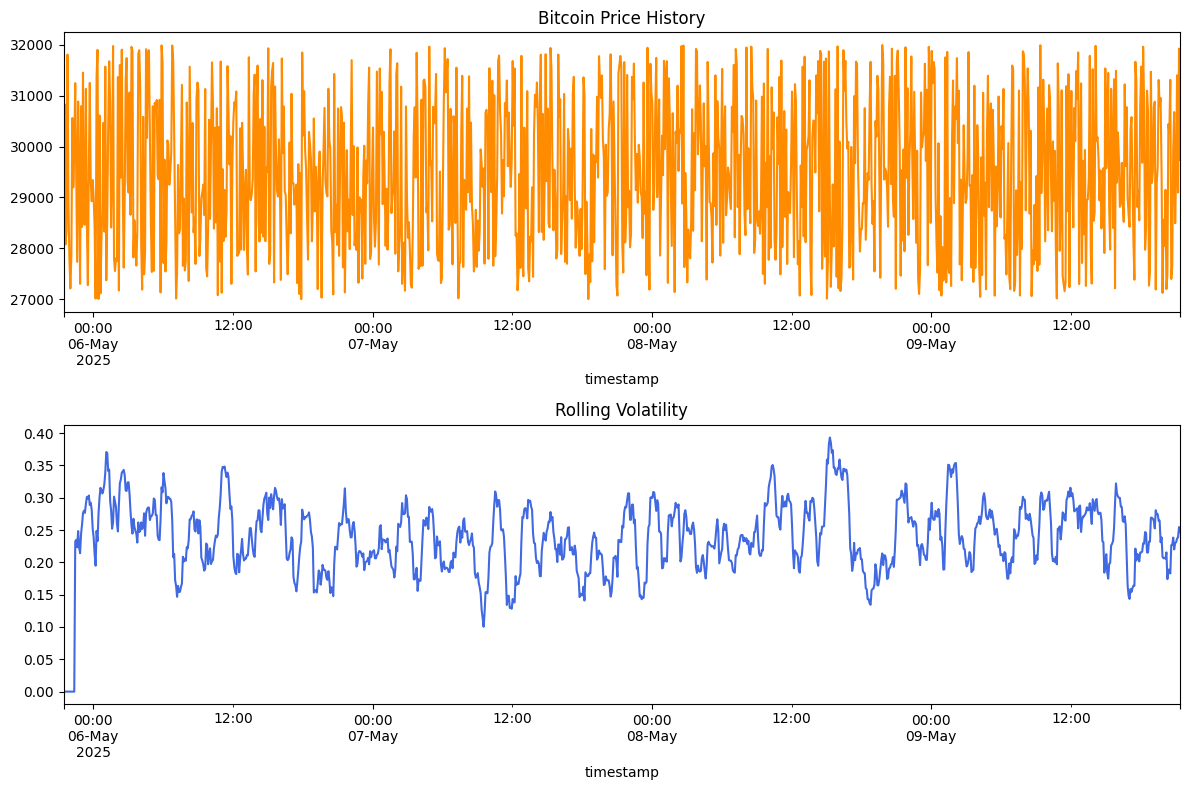

In [7]:
# Generate analysis
metrics = analyze_data(full_df)

# Plot price and volatility
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
full_df.set_index('timestamp')['price'].plot(
    ax=ax[0], 
    title='Bitcoin Price History',
    color='darkorange'
)
full_df.set_index('timestamp')['volatility'].plot(
    ax=ax[1],
    title='Rolling Volatility',
    color='royalblue'
)
plt.tight_layout()
plt.show()

In [8]:
df = add_technical_indicators(full_df)

In [9]:
# Ensure the timestamp column is set as the index
df = full_df.set_index('timestamp')

# Perform time series analysis
analysis = analyze_time_series(df)

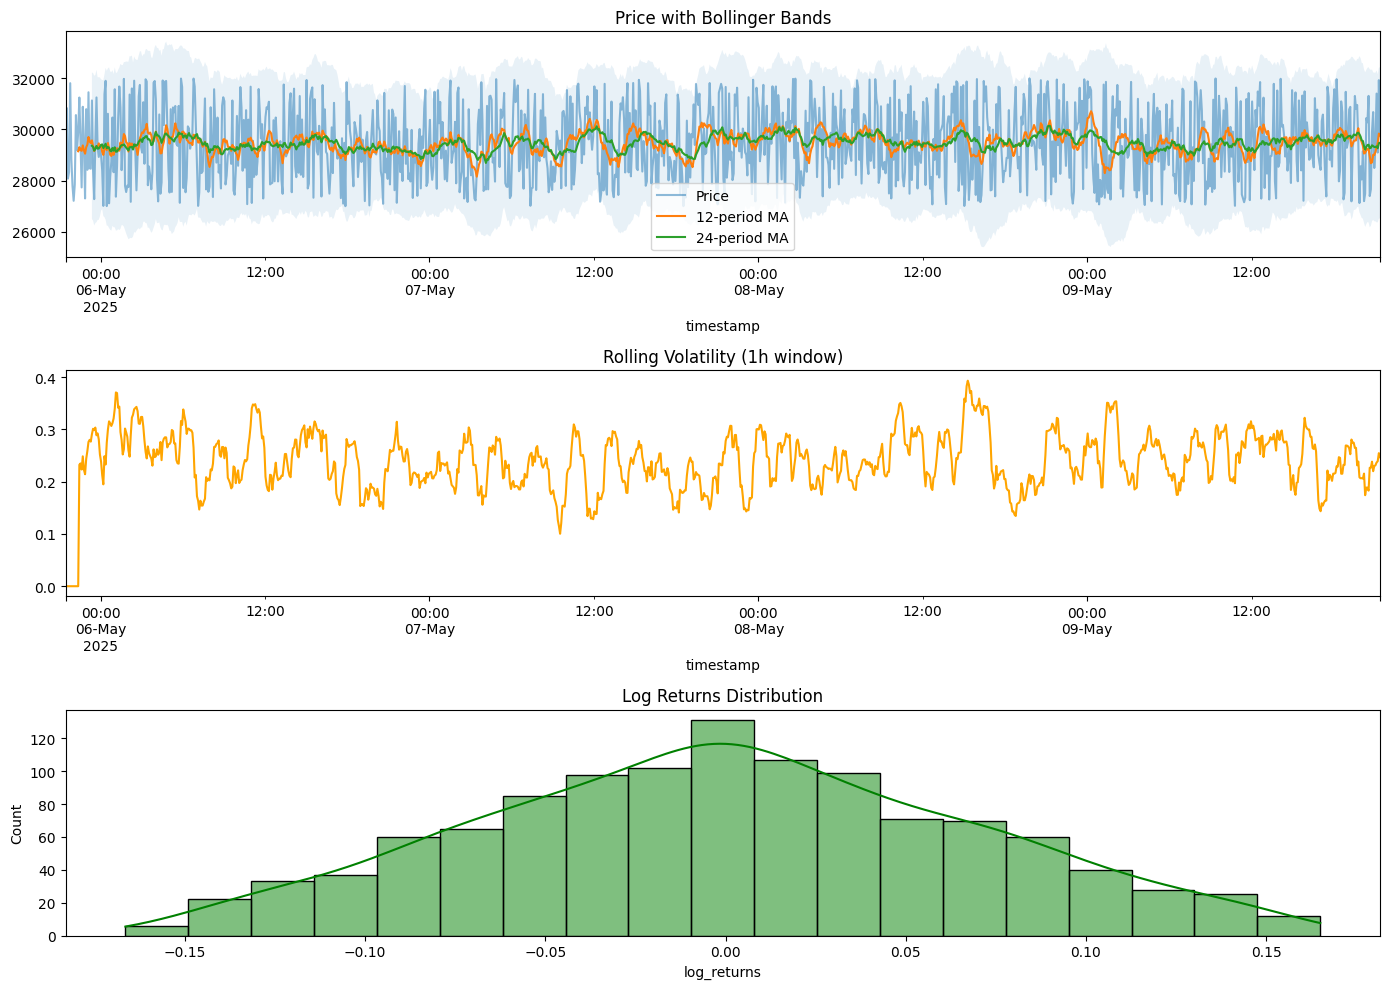

In [10]:
create_analysis_plots(df)

In [11]:
print_statistical_summary(df)

Price Statistics:
count     1152.000000
mean     29465.706198
std       1437.884980
min      27000.930000
25%      28243.637500
50%      29368.750000
75%      30748.515000
max      31994.180000
Name: price, dtype: float64

Volatility Statistics:
count    1152.000000
mean        0.239074
std         0.054776
min         0.000000
25%         0.205605
50%         0.239176
75%         0.276089
max         0.393117
Name: volatility, dtype: float64

Correlation Matrix:
               price  volatility
price       1.000000    0.042441
volatility  0.042441    1.000000

Normality Tests:
Price Jarque-Bera: SignificanceResult(statistic=69.15735658060132, pvalue=9.60883701649285e-16)
Returns Shapiro: ShapiroResult(statistic=0.9935780763626099, pvalue=7.152778562158346e-05)


In [12]:
print("\nPrice Outliers:")
print(detect_outliers(df))


Price Outliers:
Empty DataFrame
Columns: [price, volatility, log_returns, MA_12, MA_24, Upper_BB, Lower_BB, High_Vol]
Index: []


## Interactive Q&A System
Predefined example questions with enhanced output

In [13]:
questions = [
    "What was the highest price in the last 6 hours?",
    "Show me times when volatility spiked",
    "What's the current price trend?",
    "Exit"
]

for idx, question in enumerate(questions, 1):
    clear_output(wait=True)
    print(f"Question {idx}/{len(questions)}")
    print("="*30)
    
    if question == "Exit":
        break
        
    # Create context from data
    context = ""
    if "price" in question.lower():
        context = f"Recent Bitcoin prices:\n{full_df[['timestamp', 'price']].tail(12).to_string()}"
    elif "volatility" in question.lower():
        context = f"Volatility anomalies:\n{metrics['recent_anomalies'].tail(3).to_string()}"
    
    # Get answer with context
    answer = handle_query(llm, f"{context}\n{question}")
    
    # Print formatted output
    print(f"\nQ: {question}")
    print(f"\nA: {answer}\n")
    
    # Show supporting data
    if context:
        print("\nSupporting Data:")
        print(context)
    
    if idx < len(questions):
        input("\nPress Enter to continue...")


Question 4/4


## Advanced Query Demonstration
Custom question input with data context

In [14]:
run_bitcoin_chatbot(llm, full_df)

Bitcoin Data Chatbot

You: What is the trend of bitcoin prices


Llama.generate: 1 prefix-match hit, remaining 749 prompt tokens to eval
llama_perf_context_print:        load time =   72350.06 ms
llama_perf_context_print: prompt eval time =  127163.59 ms /   749 tokens (  169.78 ms per token,     5.89 tokens per second)
llama_perf_context_print:        eval time =   30438.81 ms /    77 runs   (  395.31 ms per token,     2.53 tokens per second)
llama_perf_context_print:       total time =  157644.77 ms /   826 tokens



You: What is the trend of bitcoin prices


Assistant: The trend of Bitcoin prices is upward. The prices have been steadily increasing over the past few years, with a few minor dips and spikes along the way. According to the data, the price has increased by approximately 300% over the past 5 years, and by over 500% over the past 10 years.

You: what is the average bitcoin price for last 2 days


Llama.generate: 827 prefix-match hit, remaining 24 prompt tokens to eval
llama_perf_context_print:        load time =   72350.06 ms
llama_perf_context_print: prompt eval time =    5011.15 ms /    24 tokens (  208.80 ms per token,     4.79 tokens per second)
llama_perf_context_print:        eval time =    6284.02 ms /    20 runs   (  314.20 ms per token,     3.18 tokens per second)
llama_perf_context_print:       total time =   11308.27 ms /    44 tokens



You: what is the average bitcoin price for last 2 days


Assistant: The average Bitcoin price for the last 2 days is around $1152.

You: comapare it with the current price


Llama.generate: 871 prefix-match hit, remaining 19 prompt tokens to eval
llama_perf_context_print:        load time =   72350.06 ms
llama_perf_context_print: prompt eval time =    4490.02 ms /    19 tokens (  236.32 ms per token,     4.23 tokens per second)
llama_perf_context_print:        eval time =   14214.41 ms /    48 runs   (  296.13 ms per token,     3.38 tokens per second)
llama_perf_context_print:       total time =   18722.99 ms /    67 tokens



You: comapare it with the current price


Assistant: Comparing the current price of Bitcoin ($1152) with the average price for the last 2 days ($1151.67), we can see that the current price is slightly lower than the average.

You: 
Exiting the Bitcoin Q&A bot. Goodbye!
